#Time Series model with LSTM

In this project, I'll build a Machine Learning model for Time Series data using LSTM (Long Short-Term Memory)

##1. Download Dataset from Kaggle API

The dataset for this project is the Jena Climate dataset from Kaggle

Jena Climate is a weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany. The dataset is made up of 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) that were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [ ]:
!kaggle datasets download -d mnassrib/jena-climate

 68% 9.00M/13.2M [00:00<00:00, 69.4MB/s]
100% 13.2M/13.2M [00:00<00:00, 86.3MB/s]


Extract jena-climate.zip from Kaggle and save the extracted file to Drive.

In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/jena-climate.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')  # Replace 'destination_folder' with your desired folder

Load the Dataset into the Dataframe and inspect information about the Dataset

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/jena_climate_2009_2016.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [ ]:
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


##2. Preprocessing The Dataset

I'll use Temp data from the Dataset, and drop the other columns.
Because the Dataset records data every 10 minutes, I'll only use data with 60-minute intervals.
After that, I'll inspect the data distribution

In [ ]:
df_data = df[['Date Time', 'T (degC)']].rename(columns={'T (degC)':'Temp', 'Date Time':'date'})

In [ ]:
df_data.head()

,date,Temp
0,01.01.2009 00:10:00,-8.02
1,01.01.2009 00:20:00,-8.41
2,01.01.2009 00:30:00,-8.51
3,01.01.2009 00:40:00,-8.31
4,01.01.2009 00:50:00,-8.27


Text(0.5, 1.0, 'Temperature average')

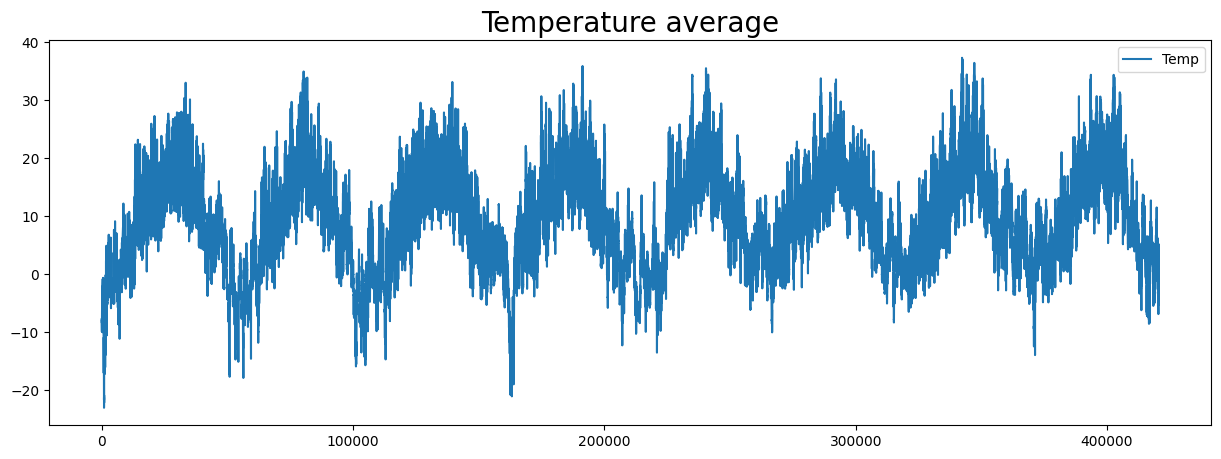

In [ ]:
import matplotlib.pyplot as plt

df_data.plot(figsize= (15,5))
plt.title('Temperature average',
           fontsize=20)

From the plot above, it seems the Dataset is seasonal data.

In [ ]:
from datetime import date
df_data['date'] = pd.to_datetime(df_data['date'])

In [ ]:
df_data_hour = df_data[5::6].reset_index().drop('index', axis=1)
df_data_hour

,date,Temp
0,2009-01-01 01:00:00,-8.05
1,2009-01-01 02:00:00,-8.88
2,2009-01-01 03:00:00,-8.81
3,2009-01-01 04:00:00,-9.05
4,2009-01-01 05:00:00,-9.63
...,...,...
70086,2016-12-31 19:10:00,-0.98
70087,2016-12-31 20:10:00,-1.40
70088,2016-12-31 21:10:00,-2.75
70089,2016-12-31 22:10:00,-2.89


Inspect data distribution using sns.distplot

<ipython-input-13-0294395e07df>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_data_hour['Temp'])


<Axes: xlabel='Temp', ylabel='Density'>

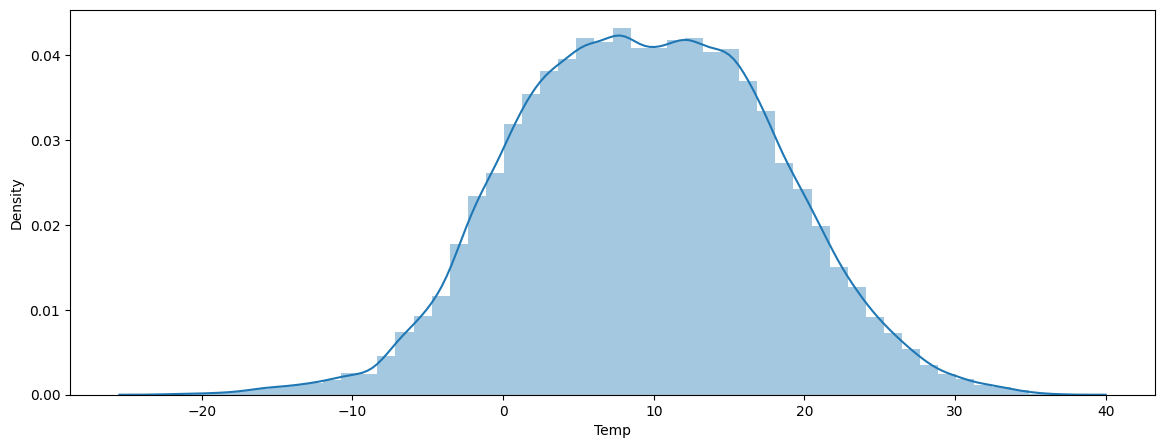

In [ ]:
import seaborn as sns

plt.figure(figsize= (14,5))
sns.distplot(df_data_hour['Temp'])

From sns.distplot, the data is normally distributed and ready to use for the model

##3. Prepare the Dataset for model

Change the data into an array using numpy array so it can be recognized by the model

In [ ]:
import numpy as np

def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)

    return np.array(X), np.array(y)


n_input = 20

df_min_model_data = df_data_hour['Temp']

X, y = Sequential_Input_LSTM(df_min_model_data, n_input)

In [ ]:
X

array([[-8.05, -8.88, -8.81, ..., -5.25, -5.11, -4.9 ],
       [-8.88, -8.81, -9.05, ..., -5.11, -4.9 , -4.8 ],
       [-8.81, -9.05, -9.63, ..., -4.9 , -4.8 , -4.5 ],
       ...,
       [-4.26, -5.05, -4.67, ..., -0.42, -0.98, -1.4 ],
       [-5.05, -4.67, -4.47, ..., -0.98, -1.4 , -2.75],
       [-4.67, -4.47, -4.9 , ..., -1.4 , -2.75, -2.89]])

In [ ]:
y

array([-4.8 , -4.5 , -4.47, ..., -2.75, -2.89, -3.93])

Because there is a requirement for mae < 10%.
I'll calculate mae threshold of the data, and the result is 6%

In [ ]:
threshold_mae = (df_data_hour['Temp'].max() - df_data_hour['Temp'].min()) * 10/100
threshold_mae

6.004000000000001

After that, I'll split the train data and validation data using train_test_split, to split validation data 20% from all data

In [ ]:
from sklearn.model_selection import train_test_split


X_latih, X_val, y_latih, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
len(X_latih)

56056

In [ ]:
len(X_val)

14015

Reshaped the data from a 2D array into a 3D array so the model could recognize it

In [ ]:
X_latih_reshaped = np.reshape(X_latih, (X_latih.shape[0], X_latih.shape[1], 1))

In [ ]:
X_latih_reshaped

array([[[-8.05],
        [-8.88],
        [-8.81],
        ...,
        [-5.25],
        [-5.11],
        [-4.9 ]],

       [[-8.88],
        [-8.81],
        [-9.05],
        ...,
        [-5.11],
        [-4.9 ],
        [-4.8 ]],

       [[-8.81],
        [-9.05],
        [-9.63],
        ...,
        [-4.9 ],
        [-4.8 ],
        [-4.5 ]],

       ...,

       [[12.85],
        [12.55],
        [12.24],
        ...,
        [19.03],
        [18.46],
        [17.93]],

       [[12.55],
        [12.24],
        [11.97],
        ...,
        [18.46],
        [17.93],
        [16.92]],

       [[12.24],
        [11.97],
        [11.66],
        ...,
        [17.93],
        [16.92],
        [15.82]]])

##4. Model

Make Sequential model using 3 LSTM layer

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(X_latih.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1),
])

Print model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 20, 100)           80400     
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 5)                 130       
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 152811 (596.92 KB)
Trainable params: 15281

And then visualize the model using keras plot_model

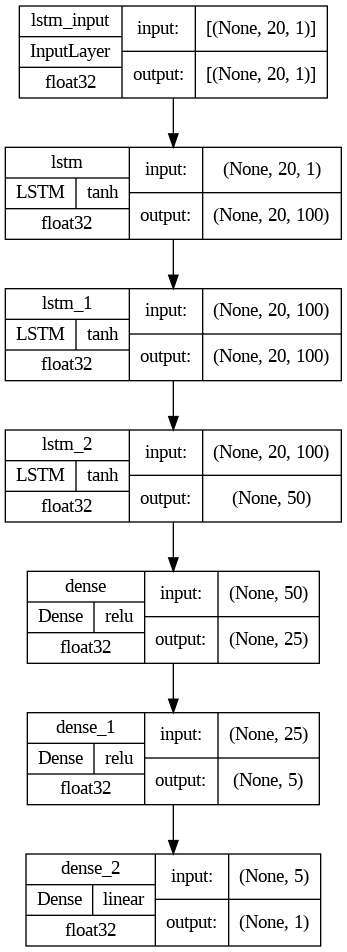

In [ ]:
from tensorflow import keras

keras.utils.plot_model(
    model,
    show_shapes = True,
    show_dtype = True,
    show_layer_activations = True
)

##5. Train Model
Train the model using SGD as an optimizer and Learning Rate = 0.0001.
I'll use Huber for loss, and mae as metrics
The data will be trained with epoch=50

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=['mae'])
history = model.fit(X_latih, y_latih,
                    validation_data = (X_val, y_val),
                    epochs=50)

Epoch 1/50
1752/1752 [==============================] - 53s 28ms/step - loss: 4.1233 - mae: 4.5913 - val_loss: 2.0620 - val_mae: 2.5046
Epoch 2/50
1752/1752 [==============================] - 47s 27ms/step - loss: 1.4033 - mae: 1.8247 - val_loss: 0.7141 - val_mae: 1.0990
Epoch 3/50
1752/1752 [==============================] - 47s 27ms/step - loss: 0.8617 - mae: 1.2435 - val_loss: 0.4810 - val_mae: 0.8287
Epoch 4/50
1752/1752 [==============================] - 48s 27ms/step - loss: 0.6122 - mae: 0.9636 - val_loss: 0.3688 - val_mae: 0.6914
Epoch 5/50
1752/1752 [==============================] - 48s 27ms/step - loss: 0.4745 - mae: 0.8086 - val_loss: 0.3718 - val_mae: 0.7109
Epoch 6/50
1752/1752 [==============================] - 47s 27ms/step - loss: 0.4161 - mae: 0.7426 - val_loss: 0.3131 - val_mae: 0.6261
Epoch 7/50
1752/1752 [==============================] - 48s 27ms/step - loss: 0.3795 - mae: 0.7012 - val_loss: 0.2941 - val_mae: 0.5998
Epoch 8/50
1752/1752 [==========================

From the trained result, mae is 0,5035 and val_mae is 0,4976

##6. Plotting Mae

Last, I'll be plotting mae and val_mae using Pyplot

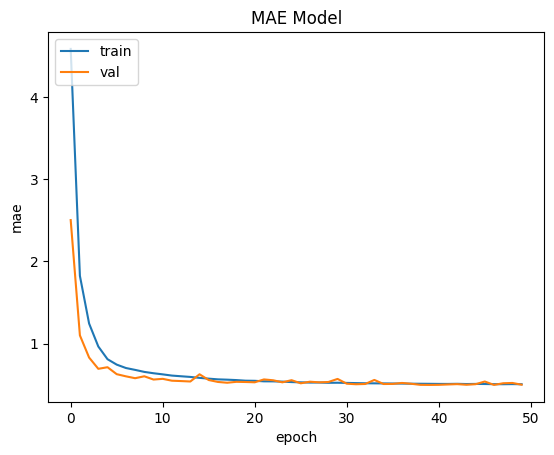

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()